#### Section 2.6: Single Assay Pair Analysis

#### Depreated due to updated analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import metrics 
from matplotlib.ticker import PercentFormatter

In [3]:
raw_dat_dir = '/home/grace/Documents/python/genetox/data/raw/'
processed_dat_dir = '/home/grace/Documents/python/genetox/data/processed/'
interim_dat_dir = '/home/grace/Documents/python/genetox/data/interim/'
figures_dir = '/home/grace/Documents/python/genetox/reports/figures/'

In [4]:
xls = pd.ExcelFile(raw_dat_dir+'Chemicals&AssayData.xlsx')

In [5]:
xls.sheet_names

['all_genetox_exptdata']

In [6]:
genetox = xls.parse('all_genetox_exptdata')

In [13]:
#genetox

In [7]:
df_demarini = pd.read_csv(processed_dat_dir+'DeMariniCalls.csv')

In [20]:
df_demarini.head()

,CASRN,DeMarini_call,DTXSID,DeMarini_outcome
0,75-07-0,clastogen,DTXSID5039224,1.0
1,50-81-7,clastogen,DTXSID5020106,1.0
2,100-52-7,clastogen,DTXSID8039241,1.0
3,119-53-9,clastogen,DTXSID1020144,1.0
4,140-11-4,clastogen,DTXSID0020151,1.0


In [8]:
tag = {'clastogen':1, 'gentox':1, 'non gentox':0,  'inconclusive':np.nan,
       'not clastogen':0}

In [10]:
df_demarini['DeMarini_outcome'] = df_demarini['DeMarini_call'].replace(tag)

#### Resampling: Sample 1 ames and 1 clastogen activity for each chemical from the experimental data (underlying distribution). 
> - For each sample derive the Genetox classification as per the categorisation scheme
> - Calculate the overall variance/accuracy of agreement as a measure of reproducibility
> - Calculate the unalikability index as a measure of overall agreeability of experimental values/chemical

In [29]:
n_bootstraps = 500
AmesSubsetforBootstrap = pd.DataFrame(index=[], \
                                      columns=['CASRN','AmesOutcomeArraynoInc', '%AmesPos', '%AmesNeg','AmesUnalikeability',\
                                               'AmesBootstrappedArray', '%bAmesPos', '%bAmesNeg','AmesBUnalikeability',\
                                               'ClasOutcomeArraynoInc', '%ClasPos', '%ClasNeg','ClasUnalikeability',\
                                               'ClasBootstrappedArray', '%bClasPos', '%bClasNeg','ClasBUnalikeability',\
                                               'DeMariniBootstrapped'])
idx = 0
for cas, group in genetox.groupby('casrn'):
    #cas = group['casrn'].unique()
    AmesOutcomeArray = np.array(group[group['simple_aggregate']=='Ames']['assay_outcome'])
    ClasOutcomeArray = np.array(group[group['simple_aggregate']=='clastogen']['assay_outcome'])
    # Remove all the inconclusive outcomes
    AmesOutcomeArraynoInc = AmesOutcomeArray[~np.isin(AmesOutcomeArray,(2))]
    ClasOutcomeArraynoInc = ClasOutcomeArray[~np.isin(ClasOutcomeArray,(2))]
    if len(AmesOutcomeArraynoInc) > 2:
        # create a bootstraped value array
        AmesBootstrapvalues = np.array(np.random.choice(AmesOutcomeArraynoInc, replace=True, size=n_bootstraps))
        try:
            ClasBootstrapvalues = np.array(np.random.choice(ClasOutcomeArraynoInc, replace=True, size=n_bootstraps))
        except:
            ClasBootstrapvalues = np.array([])
        # Calculate the % of 0,1 and 2 (non-mutagenic, mutagenic and inconclusives) in original data
        AmesPercPos = 100*(AmesOutcomeArraynoInc==1).sum()/len(AmesOutcomeArraynoInc)
        AmesPercNeg = 100*(AmesOutcomeArraynoInc==0).sum()/len(AmesOutcomeArraynoInc)
        Amesunalikeability = 2*AmesPercPos*AmesPercNeg/10000 #keep it as a number between 0 and 1
        #PercInc = 100*(AmesOutcomeArraynoInc==2).sum()/len(AmesOutcomeArraynoInc)
        # Calculate the % of 0,1 and 2 (clastogenicity) in original data
        ClasPercPos = 100*(ClasOutcomeArraynoInc==1).sum()/len(ClasOutcomeArraynoInc)
        ClasPercNeg = 100*(ClasOutcomeArraynoInc==0).sum()/len(ClasOutcomeArraynoInc)
        Clasunalikeability = 2*ClasPercPos*ClasPercNeg/10000 #keep it as a number between 0 and 1
        
        # Calculate the % of 0,1 and 2 (non-mutagenic, mutagenic and inconclusives) in bootsstrapped data
        AmesBPercPos = 100*(AmesBootstrapvalues==1).sum()/n_bootstraps
        AmesBPercNeg = 100*(AmesBootstrapvalues==0).sum()/n_bootstraps
        AmesBunalikeability = 2*AmesBPercPos*AmesBPercNeg/10000 #keep it as a number between 0 and 1
        #bPercInc = 100*(bootstrapvalues==2).sum()/n_bootstraps
        # Calculate the % of 0,1 and 2 (clastogenicity) in bootsstrapped data
        ClasBPercPos = 100*(ClasBootstrapvalues==1).sum()/n_bootstraps
        ClasBPercNeg = 100*(ClasBootstrapvalues==0).sum()/n_bootstraps
        ClasBunalikeability = 2*ClasBPercPos*ClasBPercNeg/10000 #keep it as a number between 0 and 1
               
        # Derive DeMarini Call for each bootstrap
        bootstrapdemarini = []
        for i, ames in enumerate(AmesBootstrapvalues):
            if ames == 1:
                bootstrapdemarini.append(1)
            else:
                try:
                    clas = ClasBootstrapvalues[i]
                    if clas == 1:
                        bootstrapdemarini.append(1)
                    else:
                        bootstrapdemarini.append(0)   
                except:
                    bootstrapdemarini.append(0)
            
        # Update the DataFrame
        AmesSubsetforBootstrap.loc[idx,'CASRN'] = cas
        #Ames
        AmesSubsetforBootstrap.loc[idx, 'AmesOutcomeArraynoInc'] = AmesOutcomeArraynoInc
        AmesSubsetforBootstrap.loc[idx, '%AmesPos']= AmesPercPos
        AmesSubsetforBootstrap.loc[idx, '%AmesNeg'] = AmesPercNeg
        AmesSubsetforBootstrap.loc[idx, 'AmesUnalikeability'] = Amesunalikeability
        AmesSubsetforBootstrap.loc[idx, 'AmesBootstrappedArray'] = AmesBootstrapvalues
        AmesSubsetforBootstrap.loc[idx, '%bAmesPos']= AmesBPercPos
        AmesSubsetforBootstrap.loc[idx, '%bAmesNeg'] = AmesBPercNeg    
        AmesSubsetforBootstrap.loc[idx, 'AmesBUnalikeability'] = float(AmesBunalikeability)
        # Clas
        AmesSubsetforBootstrap.loc[idx, 'ClasOutcomeArraynoInc'] = ClasOutcomeArraynoInc
        AmesSubsetforBootstrap.loc[idx, '%ClasPos']= ClasPercPos
        AmesSubsetforBootstrap.loc[idx, '%ClasNeg'] = ClasPercNeg
        AmesSubsetforBootstrap.loc[idx, 'ClasUnalikeability'] = Clasunalikeability
        AmesSubsetforBootstrap.loc[idx, 'ClasBootstrappedArray'] = ClasBootstrapvalues
        AmesSubsetforBootstrap.loc[idx, '%bClasPos']= ClasBPercPos
        AmesSubsetforBootstrap.loc[idx, '%bClasNeg'] = ClasBPercNeg    
        AmesSubsetforBootstrap.loc[idx, 'ClasBUnalikeability'] = float(ClasBunalikeability)
        # DeMarini calls
        AmesSubsetforBootstrap.loc[idx, 'DeMariniBootstrapped'] = bootstrapdemarini
        # Update the index
        idx=idx+1

AmesSubsetforBootstrap.index = AmesSubsetforBootstrap['CASRN']
AmesSubsetforBootstrap.to_csv(processed_dat_dir+'AmesBootstrapAnalysis.csv', index_label = 'CASRN')   



/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [30]:
AmesSubsetforBootstrap.head()

,CASRN,AmesOutcomeArraynoInc,%AmesPos,%AmesNeg,AmesUnalikeability,AmesBootstrappedArray,%bAmesPos,%bAmesNeg,AmesBUnalikeability,ClasOutcomeArraynoInc,%ClasPos,%ClasNeg,ClasUnalikeability,ClasBootstrappedArray,%bClasPos,%bClasNeg,ClasBUnalikeability,DeMariniBootstrapped
CASRN,,,,,,,,,,,,,,,,,,
100-00-5,100-00-5,"[1, 1, 1, 1, 1]",100,0,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",100,0,0,"[1, 1]",100,0,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",100,0,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
100-02-7,100-02-7,"[0, 1, 0, 1, 0]",40,60,0.48,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...",40.8,59.2,0.483072,[],NaN,NaN,NaN,[],0,0,0,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
100-36-7,100-36-7,"[0, 0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,[],NaN,NaN,NaN,[],0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
100-40-3,100-40-3,"[0, 0, 0, 0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,[],NaN,NaN,NaN,[],0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
100-41-4,100-41-4,"[0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 1, 1]",40,60,0.48,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",44.2,55.8,0.493272,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."


In [43]:
AmesSubsetforBootstrap.shape

(2167, 18)

In [34]:
df_demarini = df_demarini.set_index('CASRN')

#### Calculate equivalence|accuracy of bootstrap DeMarini against original DeMarini calls

In [35]:

evaluationdataset = pd.concat([AmesSubsetforBootstrap['DeMariniBootstrapped'], df_demarini], axis = 1).dropna()


In [36]:
evaluationdataset

,DeMariniBootstrapped,DeMarini_call,DTXSID,DeMarini_outcome
100-00-5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",gentox,DTXSID5020281,1.0
100-02-7,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...",gentox,DTXSID0021834,1.0
100-36-7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,DTXSID7057606,0.0
100-40-3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,DTXSID3021437,0.0
100-41-4,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",clastogen,DTXSID3020596,1.0
...,...,...,...,...
99305-42-7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,DTXSID90893706,0.0
994-05-8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",clastogen,DTXSID8024521,1.0
99591-74-9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",gentox,DTXSID60469235,1.0
996-35-0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,DTXSID2033447,0.0


In [37]:
#AmesSubsetforBootstrap['DeMarini'] = df_demarini
bootstrapacc = []
for idx in evaluationdataset.index:
    x = np.empty(n_bootstraps)
    x.fill(evaluationdataset.loc[idx, 'DeMarini_outcome'])
    y = evaluationdataset.loc[idx, 'DeMariniBootstrapped']
    acc = 100*np.round(metrics.accuracy_score(x, y),2)
    evaluationdataset.loc[idx, 'DeMariniBootstrappedAccuracy'] = acc


In [40]:
evaluationdataset.head()

,DeMariniBootstrapped,DeMarini_call,DTXSID,DeMarini_outcome,DeMariniBootstrappedAccuracy
100-00-5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",gentox,DTXSID5020281,1.0,100.0
100-02-7,"[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...",gentox,DTXSID0021834,1.0,41.0
100-36-7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,DTXSID7057606,0.0,100.0
100-40-3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,DTXSID3021437,0.0,100.0
100-41-4,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",clastogen,DTXSID3020596,1.0,44.0


#### Plot Unalikeability

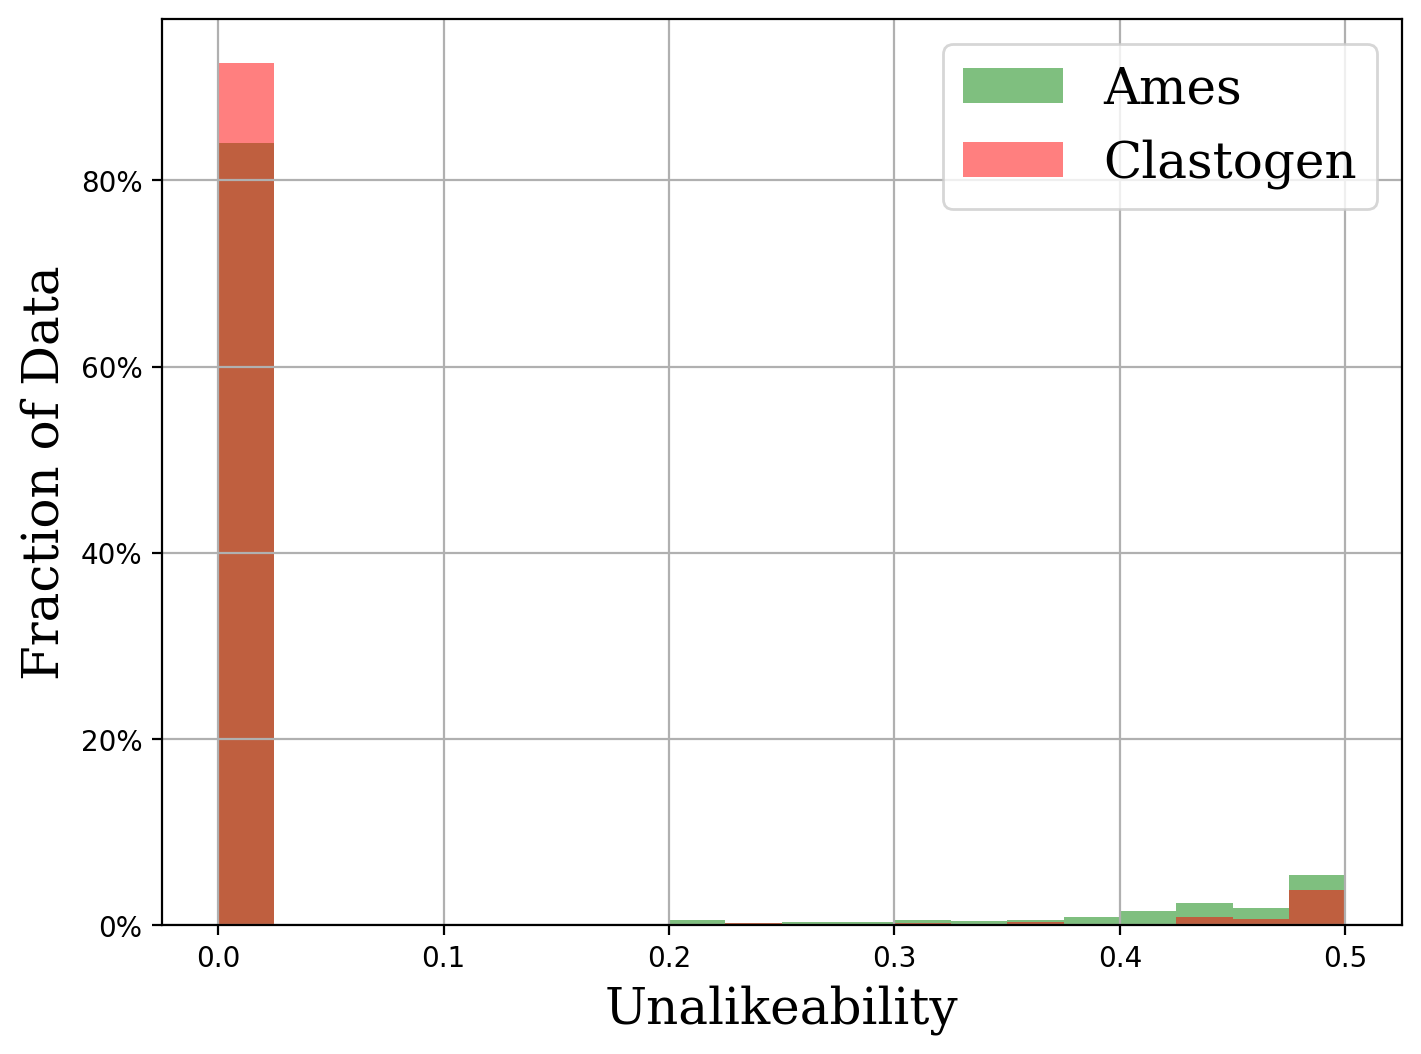

In [41]:
# a. Plot Unalikeability
#-----------------------
plt.figure(figsize=(8, 6), dpi = 200)
Amestotaldata = len(AmesSubsetforBootstrap['AmesBUnalikeability'].dropna())
AmesSubsetforBootstrap['AmesBUnalikeability'].astype('float64').hist(bins=20,  weights=np.ones(Amestotaldata)/(Amestotaldata), color='g', alpha=0.5, label='Ames')

Clastotaldata = len(AmesSubsetforBootstrap['ClasBUnalikeability'].dropna())
AmesSubsetforBootstrap['ClasBUnalikeability'].astype('float64').hist(bins=20,  weights=np.ones(Clastotaldata)/(Clastotaldata), color='r', alpha=0.5, label='Clastogen')

plt.legend(prop={'size':18,'family':'serif'})
plt.xlabel('Unalikeability', fontsize=18, family = 'serif')
plt.ylabel('Fraction of Data', fontsize=18, family = 'serif')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig(figures_dir+'unalikeability.png', bbox_inches='tight')

#### Figure 6: Plot reproducibility

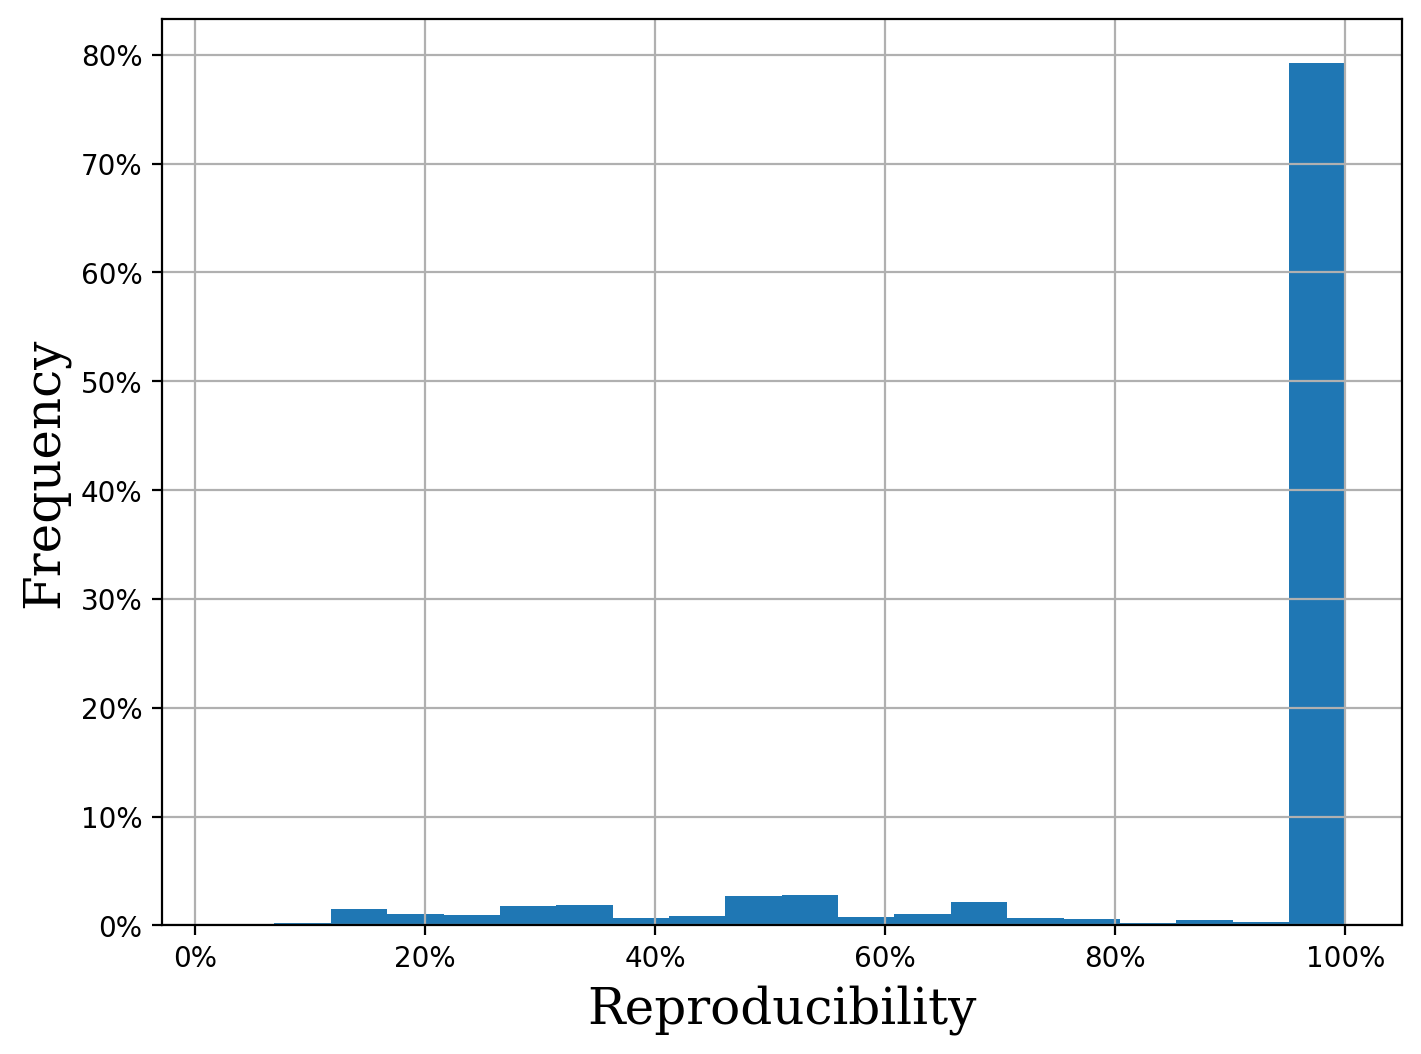

In [42]:
plt.figure(figsize=(8, 6), dpi = 200)
plt.grid(True)
totaldata = len(evaluationdataset['DeMariniBootstrappedAccuracy'])
plt.hist(evaluationdataset['DeMariniBootstrappedAccuracy'], bins=20,  weights=np.ones(totaldata)/(totaldata))
#plt.legend(prop={'size':18,'family':'serif'})
plt.xlabel('Reproducibility', fontsize=18, family = 'serif')
plt.ylabel('Frequency', fontsize=18, family = 'serif')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(100))
plt.savefig(figures_dir+'demariniReproducibility.png', bbox_inches='tight')
#%%